In [1]:
import json
import numpy as np
import pandas as pd
from clean import CleanData
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = json.load(open('./data/trending.json', encoding="utf8"))
data = data['collector']
toParse = pd.json_normalize(data)
df = CleanData(toParse)
df.process_the_data()
df.summary_of_data()

Missing Data:
None

Data Time Period:
Start Date: 2020-09-22 14:22:38
  End Date: 2020-12-21 03:18:36
 Timedelta: 89 days 12:55:58


In [3]:
df_clean = df.dfm
# df_clean[df_clean.likeCount == min(df_clean.likeCount)].T
df_clean.sort_values(by=['likeCount'],ascending=False).head(3).T

,947,349,706
id,6894081763379924229,6885766692627107077,6890571273110392065
text,#TimeWarpScan,Beatbox keeping me sane before my flight 🗣✈️,How to draw hand #artchallenge #drawing
createTime,2020-11-12 03:58:55,2020-10-20 18:12:03,2020-11-02 16:55:47
webVideoUrl,https://www.tiktok.com/@billieeilish/video/689...,https://www.tiktok.com/@spencerx/video/6885766...,https://www.tiktok.com/@condsty/video/68905712...
likeCount,31000000,5200000,5000000
shareCount,220100,31600,110900
playCount,250800000,44600000,68700000
commentCount,625700,32000,12200
downloaded,True,True,True
mentions,[],[],[]


In [4]:
segmentDf = df_clean[['authorMeta.name','authorMeta.verified','shareRate','likeRate','commentRate','playCount','shareCount','likeCount','commentCount']]
segmentDf = segmentDf.groupby(['authorMeta.name','authorMeta.verified'],as_index=False).agg(np.mean)
segmentDf = segmentDf.sort_values(by='likeRate',ascending=False)#.head(3).T
segmentDf.head(3).T

,57,399,595
authorMeta.name,anwarali0125,l3fty_fr3ak,reus.fx
authorMeta.verified,False,False,False
shareRate,0.003181,0.020488,0.017623
likeRate,0.485684,0.446655,0.375128
commentRate,0.008484,0.011573,0.007987
playCount,943.0,55300.0,232950.0
shareCount,3.0,1133.0,4390.0
likeCount,458.0,24700.0,87850.0
commentCount,8.0,640.0,1832.0


In [5]:
segmentDf.columns

Index(['authorMeta.name', 'authorMeta.verified', 'shareRate', 'likeRate',
       'commentRate', 'playCount', 'shareCount', 'likeCount', 'commentCount'],
      dtype='object')

In [6]:
segmentDf['authorMeta.verified'].value_counts()

False    759
True      43
Name: authorMeta.verified, dtype: int64

(array([0, 1]), [Text(0, 0, 'False'), Text(1, 0, 'True')])

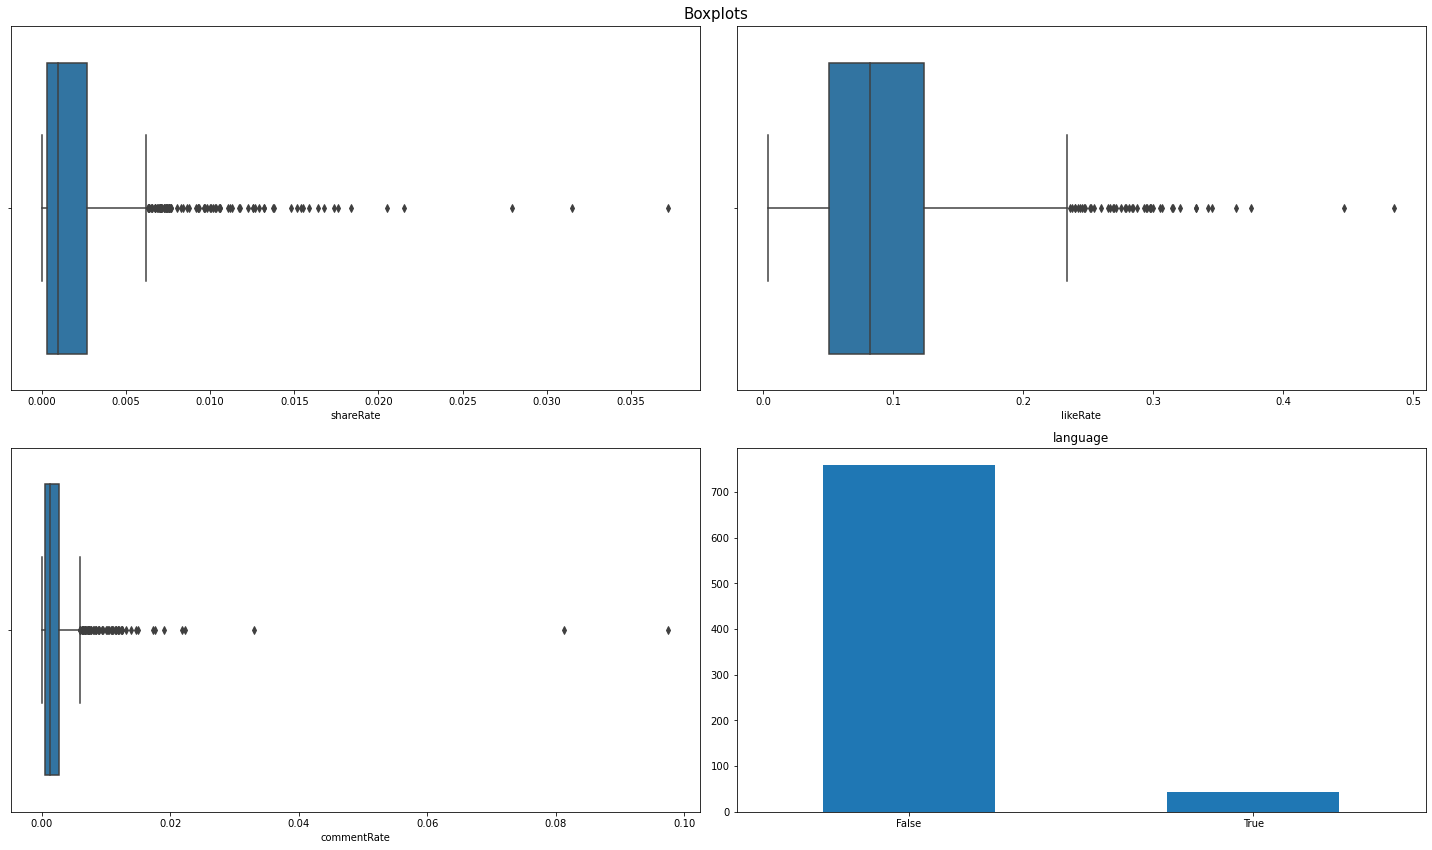

In [7]:
# fig = plt.figure(figsize=(10,10),tight_layout=True)
# ax = fig.add_subplot(111)
# ax.bar(segmentDf['authorMeta.name'], segmentDf.likeRate)
# plt.show()

fig = plt.figure(figsize=(20, 12), tight_layout=True)
plt.suptitle('Boxplots', fontsize=15)
fig.add_subplot(221)
sns.boxplot(x='shareRate', data=segmentDf)
fig.add_subplot(222)
sns.boxplot(x='likeRate', data=segmentDf)
fig.add_subplot(223)
sns.boxplot(x='commentRate', data=segmentDf)
fig.add_subplot(224)
segmentDf['authorMeta.verified'].value_counts().plot(kind='bar', title='language')
plt.xticks(rotation=0)